In [1]:
from transformers import VideoMAEImageProcessor, VideoMAEForPreTraining
import numpy as np
import torch
import os
import deepscience as ds
import matplotlib.pyplot as plt
from transformers.utils.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import h5py

[2023-08-16 14:21:15,121] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
num_frames = 16
n_channels = 3
assert n_channels == 3, "If not 3, VideoMAE default normalization behaves slightly differntly"

In [3]:
processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = VideoMAEForPreTraining.from_pretrained("MCG-NJU/videomae-base")

In [4]:
data_base_path = "/mnt/home/gkrawezik/ceph/AI_DATASETS/PDEBench/2D/CFD/"
data_rand_path = os.path.join(data_base_path, "2D_Train_Rand")
data_turb_path = os.path.join(data_base_path, "2D_Train_Turb")
data_rand_filename = '2D_CFD_Rand_M0.1_Eta0.1_Zeta0.1_periodic_128_Train.hdf5'
data_turb_filename = '2D_CFD_Turb_M0.1_Eta1e-08_Zeta1e-08_periodic_512_Train.hdf5'
data_type = "compNS"

In [5]:
# Load data
data_rand = h5py.File(os.path.join(data_rand_path, data_rand_filename), 'r')

In [6]:
data_rand['Vx'].shape

(10000, 21, 128, 128)

In [10]:
dataset_train = ds.datasets.PDEBench(dset_paths=[data_turb_path], dset_types=[data_type], split='train', n_steps=num_frames, dt=1)

In [13]:
len(dataset_train)

10000

In [11]:
num_batches = 1
batch_size = 3

data_loader_train, sampler_train = dataset_train.get_default_loader(batch_size=batch_size, epoch_size=num_batches, num_workers=1, distributed=False)

In [12]:
for batch in data_loader_train:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([3, 16, 4, 512, 512]) torch.Size([3, 4, 512, 512]) torch.Size([3, 4])


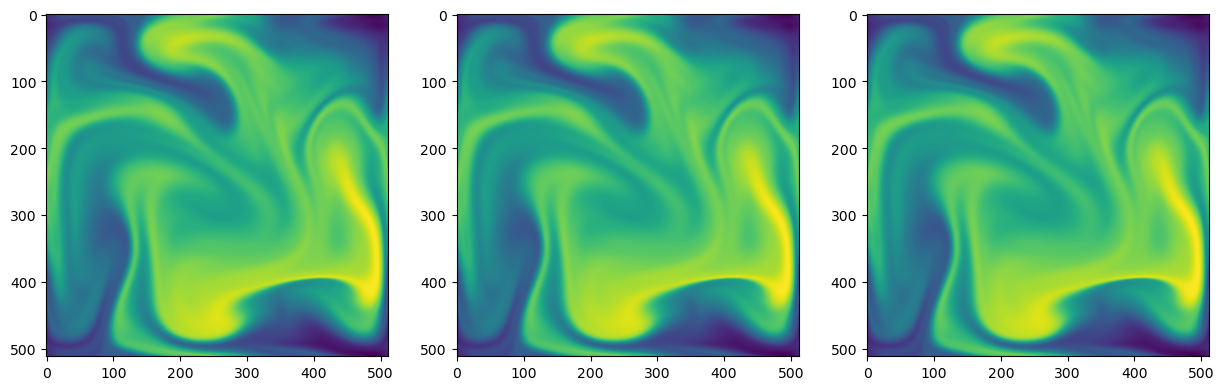

In [8]:
for batch, meta1, meta2 in data_loader_train:
    batch = batch[:, :, 2]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(batch[0, 5].numpy())
    axs[1].imshow(batch[0, 6].numpy())
    axs[2].imshow(batch[0, 7].numpy())
    plt.show()
    break

In [9]:
for batch, meta1, meta2 in data_loader_train:
    video = batch[0, :, :n_channels, :224, :224]
    print(video.shape)

torch.Size([16, 3, 224, 224])


In [10]:
pixel_values = processor(list(video), return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 16, 3, 224, 224])


/mnt/home/bregaldosaintblancard/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(value)


In [11]:
print(model.config.image_size, model.config.patch_size, model.config.tubelet_size)

224 16 2


In [12]:
print(model.config)

VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base",
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.27.0.dev0",
  "tubelet_size": 2,
  "use_mean_pooling": false
}



In [13]:
num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2
seq_length = (num_frames // model.config.tubelet_size) * num_patches_per_frame
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()
print(num_patches_per_frame, seq_length, bool_masked_pos.shape)

outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
loss = outputs.loss
print(loss)

196 1568 torch.Size([1, 1568])


tensor(0.3743, grad_fn=<MseLossBackward0>)


In [14]:
if n_channels == 3:
    mean_imagenet = torch.as_tensor(IMAGENET_DEFAULT_MEAN).to(pixel_values.device)[None, :, None, None]
    std_imagenet = torch.as_tensor(IMAGENET_DEFAULT_STD).to(pixel_values.device)[None, :, None, None]
    # Remove imagenet normalization, see VideoMAEForPreTraining.forward for more details
    pixel_values = pixel_values*std_imagenet + mean_imagenet

In [15]:
logits = outputs.logits
print(logits.shape)
logits = logits.reshape(logits.shape[0], logits.shape[1], model.config.tubelet_size, model.config.patch_size, model.config.patch_size, 3)
print(logits.shape)

torch.Size([1, 780, 1536])
torch.Size([1, 780, 2, 16, 16, 3])


In [16]:
pixel_values_reshaped = pixel_values.reshape((pixel_values.shape[0],
                                            pixel_values.shape[1]//model.config.tubelet_size,
                                            model.config.tubelet_size,
                                            pixel_values.shape[2],
                                            pixel_values.shape[3]//model.config.patch_size,
                                            model.config.patch_size,
                                            pixel_values.shape[4]//model.config.patch_size,
                                            model.config.patch_size))
print(pixel_values_reshaped.shape)
pixel_values_reshaped = torch.permute(pixel_values_reshaped, (0, 1, 4, 6, 2, 5, 7, 3))
print(pixel_values_reshaped.shape)
pixel_values_reshaped = pixel_values_reshaped.reshape((pixel_values_reshaped.shape[0],
                                                    pixel_values_reshaped.shape[1]*pixel_values_reshaped.shape[2]*pixel_values_reshaped.shape[3],
                                                    pixel_values_reshaped.shape[4]*pixel_values_reshaped.shape[5]*pixel_values_reshaped.shape[6]*pixel_values_reshaped.shape[7]))
print(pixel_values_reshaped.shape)
pixel_values_masked = pixel_values_reshaped[:, bool_masked_pos[0]]
print(pixel_values_masked.shape)
pixel_values_nonmasked = pixel_values_reshaped[:, ~bool_masked_pos[0]]
print(pixel_values_nonmasked.shape)

torch.Size([1, 8, 2, 3, 14, 16, 14, 16])
torch.Size([1, 8, 14, 14, 2, 16, 16, 3])
torch.Size([1, 1568, 1536])
torch.Size([1, 780, 1536])
torch.Size([1, 788, 1536])


In [17]:
pixel_values_masked[0, 0].shape

torch.Size([1536])

In [18]:
bool_masked_pos[0]

tensor([False,  True,  True,  ...,  True,  True,  True])

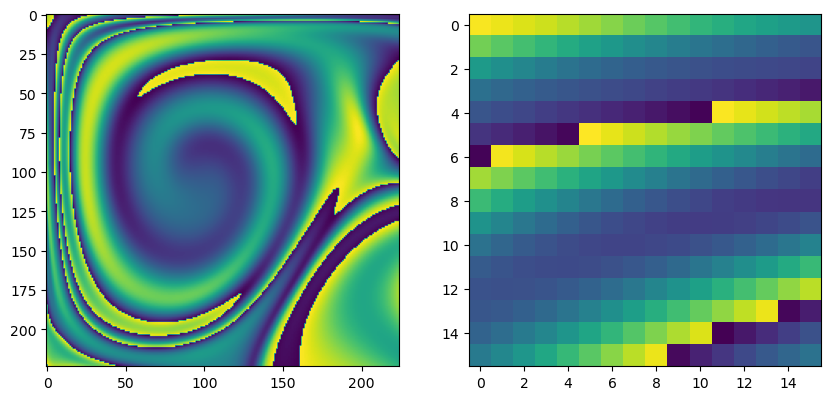

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(pixel_values[0, 0, 2])
axs[1].imshow(pixel_values[0, 0, 2, :16, 32:48])

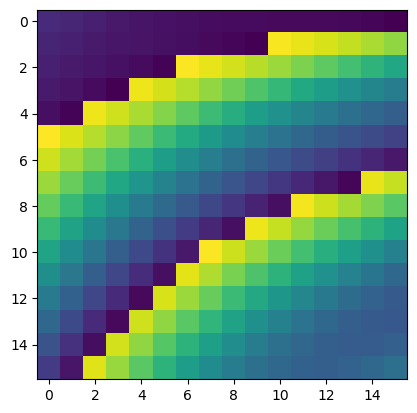

In [20]:
plt.figure()
plt.imshow(pixel_values_masked[0, 0].numpy().reshape((2, 16, 16, 3))[0, :, :, 2])

In [21]:
print(outputs.logits.shape)

torch.Size([1, 780, 1536])


torch.Size([1, 780, 2, 16, 16, 3])


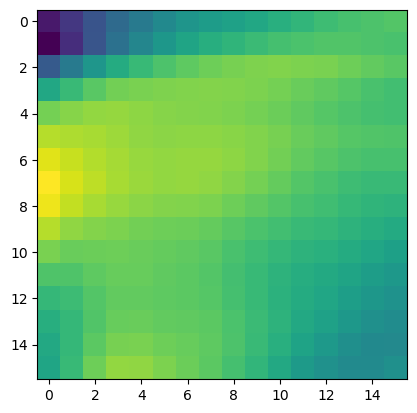

In [22]:
print(logits.shape)
plt.figure()
plt.imshow(logits[0, 0, 0, :, :, 2].detach().numpy())

In [23]:
def get_masked_pixel_values(pixel_values, bool_masked_pos, video_shape=True, return_subtensors=False, verbose=False, fill_values=torch.nan):
    pixel_values_reshaped = pixel_values.reshape((pixel_values.shape[0],
                                            pixel_values.shape[1]//model.config.tubelet_size,
                                            model.config.tubelet_size,
                                            pixel_values.shape[2],
                                            pixel_values.shape[3]//model.config.patch_size,
                                            model.config.patch_size,
                                            pixel_values.shape[4]//model.config.patch_size,
                                            model.config.patch_size))
    if verbose: print(pixel_values_reshaped.shape)
    pixel_values_reshaped = torch.permute(pixel_values_reshaped, (0, 1, 4, 6, 2, 5, 7, 3))
    if verbose: print(pixel_values_reshaped.shape)
    pixel_values_reshaped = pixel_values_reshaped.reshape((pixel_values_reshaped.shape[0],
                                                        pixel_values_reshaped.shape[1]*pixel_values_reshaped.shape[2]*pixel_values_reshaped.shape[3],
                                                        pixel_values_reshaped.shape[4]*pixel_values_reshaped.shape[5]*pixel_values_reshaped.shape[6],pixel_values_reshaped.shape[7]))
    if verbose: print(pixel_values_reshaped.shape)

    # mean_imagenet = torch.as_tensor(IMAGENET_DEFAULT_MEAN).to(pixel_values.device)[None, None, None, :]
    # std_imagenet = torch.as_tensor(IMAGENET_DEFAULT_STD).to(pixel_values.device)[None, None, None, :]

    # # Remove imagenet normalization
    # pixel_values_reshaped = pixel_values_reshaped*std_imagenet + mean_imagenet
    # print(std_imagenet, mean_imagenet)

    print(pixel_values_reshaped.shape)

    pixel_values_masked_mean = pixel_values_reshaped[:, bool_masked_pos[0]].mean(dim=-2, keepdim=True)
    pixel_values_masked_std = pixel_values_reshaped[:, bool_masked_pos[0]].std(dim=-2, keepdim=True, unbiased=True)  + 1e-6

    print(pixel_values_reshaped.shape, pixel_values_masked_mean.shape, pixel_values_masked_std.shape, fill_values.shape if isinstance(fill_values, torch.Tensor) else fill_values)

    if isinstance(fill_values, torch.Tensor):
        fill_values = torch.reshape(fill_values, (fill_values.shape[0], fill_values.shape[1], -1, n_channels))
        pixel_values_reshaped[:, bool_masked_pos[0]] = fill_values*pixel_values_masked_std + pixel_values_masked_mean
    else:
        pixel_values_reshaped[:, bool_masked_pos[0]] = fill_values
    
    pixel_values_reshaped = pixel_values_reshaped.reshape((pixel_values_reshaped.shape[0],
                                                pixel_values_reshaped.shape[1],
                                                pixel_values_reshaped.shape[2]*pixel_values_reshaped.shape[3]))

    if return_subtensors:
        pixel_values_masked = pixel_values_reshaped[:, bool_masked_pos[0]]
        if verbose: print(pixel_values_masked.shape)
        pixel_values_nonmasked = pixel_values_reshaped[:, ~bool_masked_pos[0]]
        if verbose: print(pixel_values_nonmasked.shape)
    
    if video_shape:
        pixel_values_reshaped = pixel_values_reshaped.reshape((pixel_values_reshaped.shape[0],
                                                            pixel_values.shape[1]//model.config.tubelet_size,
                                                            pixel_values.shape[3]//model.config.patch_size,
                                                            pixel_values.shape[4]//model.config.patch_size,
                                                            model.config.tubelet_size,
                                                            model.config.patch_size,
                                                            model.config.patch_size,
                                                            pixel_values.shape[2]))
        pixel_values_reshaped = torch.permute(pixel_values_reshaped, (0, 1, 4, 7, 2, 5, 3, 6))
        pixel_values_reshaped = pixel_values_reshaped.reshape((pixel_values_reshaped.shape[0],
                                                            pixel_values_reshaped.shape[1]*pixel_values_reshaped.shape[2],
                                                            pixel_values_reshaped.shape[3],
                                                            pixel_values_reshaped.shape[4]*pixel_values_reshaped.shape[5],
                                                            pixel_values_reshaped.shape[6]*pixel_values_reshaped.shape[7]))
        if verbose: print(pixel_values_reshaped.shape)

    if return_subtensors:
        return pixel_values_reshaped, pixel_values_masked, pixel_values_nonmasked
    else:
        return pixel_values_reshaped

In [24]:
pixel_values_with_masking = get_masked_pixel_values(pixel_values, bool_masked_pos)
print(pixel_values_with_masking.shape)
pixel_values_with_pred = get_masked_pixel_values(pixel_values, bool_masked_pos, fill_values=outputs.logits)

torch.Size([1, 1568, 512, 3])
torch.Size([1, 1568, 512, 3]) torch.Size([1, 780, 1, 3]) torch.Size([1, 780, 1, 3]) nan
torch.Size([1, 16, 3, 224, 224])
torch.Size([1, 1568, 512, 3])
torch.Size([1, 1568, 512, 3]) torch.Size([1, 780, 1, 3]) torch.Size([1, 780, 1, 3]) torch.Size([1, 780, 1536])


In [25]:
pixel_values.shape

torch.Size([1, 16, 3, 224, 224])

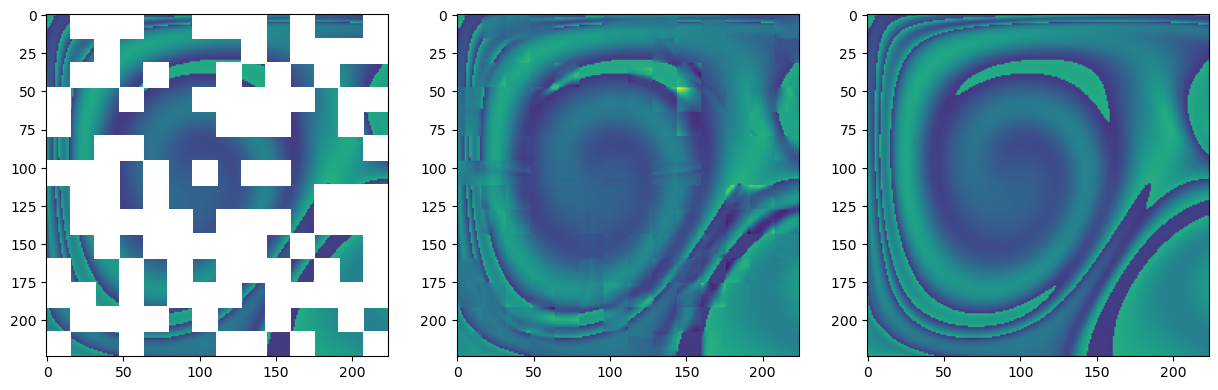

In [30]:
frame = 0
channel = 2

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
vmin, vmax = pixel_values_with_pred[0, frame, channel].min(), pixel_values_with_pred[0, frame, channel].max()
axs[0].imshow(pixel_values_with_masking[0, frame, channel], vmin=vmin, vmax=vmax)
axs[1].imshow(pixel_values_with_pred[0, frame, channel].detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].imshow(pixel_values[0, frame, channel], vmin=vmin, vmax=vmax)